# PyTorch Neural Networks

## Imports

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

## Neural Network Models

In [2]:
class Feedforward(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 10)
    
    def forwrd(self, x):
        # resize: 784
        x = x.view(x.size(0), 784)
        # linear: 784 -> 512 + relu
        x = F.relu(self.linear1(x))
        # linear: 512 -> 128 + relu
        x = F.relu(self.linear2(x))
        # linear: 128 -> 10
        x = self.linear3(x)
        
        return x

class Convolutional(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        # resize: 1@28x28
        x = x.view(x.size(0), 1, 28, 28)
        # convolution: 1@28x28 -> 16@24x24 + relu
        x = F.relu(self.conv1(x))
        # max pooling: 16@24x24 -> 16@12x12
        x = F.max_pool2d(x, 2)
        # convolution: 16@12x12 -> 32@8x8
        x = F.relu(self.conv2(x))
        # max pooling: 32@8x8 -> 32@4x4
        x = F.max_pool2d(x, 2)
        # flatten: 32@12x12 -> 512
        x = x.view(x.size(0), 512)
        # linear: 512 -> 128 + relu
        x = F.relu(self.fc1(x))
        # linear: 128 -> 64 + relu
        x = F.relu(self.fc2(x))
        # linear: 64 -> 10
        x = self.fc3(x)
        
        return x

class Recurrent(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 64
        self.num_layers = 2
        
        self.gru = nn.GRU(28, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 10)
    
    def forward(self, x):
        # init hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # resize: 28x28
        x = x.view(x.size(0), 28, 28)
        # gru: 28x28 -> 64x28 (x2)
        x, h = self.gru(x, h0)
        # linear: 64 -> 10
        x = self.linear(x[:, -1, :])
        
        return x


## Load Data

In [3]:
trainset = torchvision.datasets.FashionMNIST('./data', transform=None, download=True, train=True)
X_train = trainset.data.numpy() / 255
y_train = trainset.targets.numpy()

testset = torchvision.datasets.FashionMNIST('./data', transform=None, download=True, train=False)
X_test = testset.data.numpy() / 255
y_test = testset.targets.numpy()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Hyperparameters

In [4]:
batch_size = 64
learning_rate = 0.001
patience = 3
epochs = 10

## Convert to Tensors

In [5]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_set = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_set = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

print(len(trainloader))
print(len(testloader))

938
157


## Model, Optimizer, Loss

In [6]:
model = Convolutional()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## Check if GPU is available

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Train Function

In [8]:
def train(model, trainloader, optimizer, criterion, device, verbose=True):
    model.train()
    start = time.time()

    train_size = len(trainloader)
    total = 0
    train_loss = 0
    train_acc = 0

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        n = images.size(0)
        optimizer.zero_grad()

        # forward pass
        out = model(images)
        loss = criterion(out, labels)
        
        preds = out.argmax(dim=1)
        acc = (preds == labels).float().sum()
        train_acc += acc.item()
        train_loss += loss.item()

        # backward pass
        loss.backward()
        optimizer.step()

        current = time.time()
        if verbose:
            total += n
            print(f'[{i} / {train_size}] - {(current - start):.2f} s -', 
                f'train loss = {(train_loss / total):.4f},',
                f'train acc = {(train_acc / total):.4f}',
                end='\r'
            )
    
    train_acc /= total
    train_loss /= total
    return train_acc, train_loss

## Evaluate Function

In [9]:
def evaluate(model, testloader, criterion, device, verbose=True):
    model.eval()
    start = time.time()

    test_size = len(testloader)
    total = 0
    test_loss = 0
    test_acc = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            n = images.size(0)

            # forward pass
            out = model(images)
            loss = criterion(out, labels)
            
            preds = out.argmax(dim=1)
            acc = (preds == labels).float().sum()
            test_acc += acc.item()
            test_loss += loss.item()

            current = time.time()
            if verbose:
                total += n
                print(f'[{i} / {test_size}] - {(current - start):.2f} s -', 
                    f'test loss = {(test_loss / total):.4f},',
                    f'test acc = {(test_acc / total):.4f}',
                    end='\r'
                )
    
    test_acc /= total
    test_loss /= total
    return test_acc, test_loss

## Train for epochs

In [10]:
total_train_loss = []
total_train_acc = []
total_test_loss = []
total_test_acc = []
best_acc = 0
no_acc_change = 0

for e in range(epochs):
    print(f'=== Epoch {e + 1} ===')

    # train
    start = time.time()
    train_acc, train_loss = train(model, trainloader, optimizer, criterion, device, verbose=True)
    current = time.time()
    print(f'Train | Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}, Time: {(current - start):.2f}s')

    total_train_acc.append(train_acc)
    total_train_loss.append(train_loss)
    
    # evaluate
    start = time.time()
    test_acc, test_loss = evaluate(model, testloader, criterion, device, verbose=True)
    current = time.time()
    print(f'Test  | Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, Time: {(current - start):.2f}s')
    
    total_test_acc.append(test_acc)
    total_test_loss.append(test_loss)

    # early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        no_acc_change = 0
    else:
        no_acc_change += 1
    
    if no_acc_change >= patience:
        print('early stopping')
        break


=== Epoch 1 ===
Train | Natural Accuracy: 0.7650, Natural Loss: 0.0098, Time: 8.21s
Test  | Natural Accuracy: 0.8368, Natural Loss: 0.0069, Time: 0.64s
=== Epoch 2 ===
Train | Natural Accuracy: 0.8592, Natural Loss: 0.0061, Time: 8.07s
Test  | Natural Accuracy: 0.8688, Natural Loss: 0.0057, Time: 0.63s
=== Epoch 3 ===
Train | Natural Accuracy: 0.8806, Natural Loss: 0.0051, Time: 7.74s
Test  | Natural Accuracy: 0.8809, Natural Loss: 0.0050, Time: 0.58s
=== Epoch 4 ===
Train | Natural Accuracy: 0.8950, Natural Loss: 0.0045, Time: 7.91s
Test  | Natural Accuracy: 0.8941, Natural Loss: 0.0046, Time: 0.74s
=== Epoch 5 ===
Train | Natural Accuracy: 0.9042, Natural Loss: 0.0041, Time: 7.80s
Test  | Natural Accuracy: 0.8987, Natural Loss: 0.0045, Time: 0.62s
=== Epoch 6 ===
Train | Natural Accuracy: 0.9114, Natural Loss: 0.0038, Time: 7.61s
Test  | Natural Accuracy: 0.9050, Natural Loss: 0.0041, Time: 0.59s
=== Epoch 7 ===
Train | Natural Accuracy: 0.9159, Natural Loss: 0.0035, Time: 7.62s
Test

## Plot Results

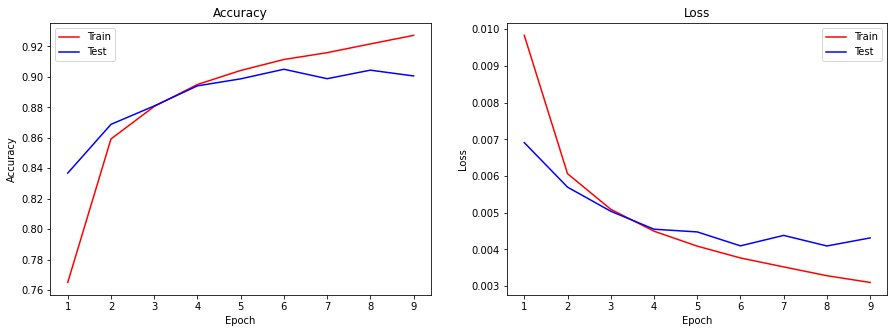

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_arr = np.arange(1, len(total_train_loss) + 1)

ax1.set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax1.plot(epochs_arr, total_train_acc, 'r', label='Train')
ax1.plot(epochs_arr, total_test_acc, 'b', label='Test')
ax1.legend()

ax2.set(title='Loss', xlabel='Epoch', ylabel='Loss')
ax2.plot(epochs_arr, total_train_loss, 'r', label='Train')
ax2.plot(epochs_arr, total_test_loss, 'b', label='Test')
ax2.legend()

plt.show()